**Generative Adversarial Networks or GANs** consist of a Generator and Discriminator model. The Generator's job is to fool the Discriminator and the Discriminator's job is to classify weather the images generated by Generator is real (1) or fake (0). 

For the purpose of this assessment I have used two different GAN Models.


1.   Traditional GAN for MNIST Dataset
2.   Deep Convolutional GAN (DCGAN) for Human Faces Dataset

My motivation to use 2 different GANs was to demonstrate the effectiveness of using Convolutional Layers in GANs for generating better results.



# Import Functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split, Dataset
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from torchvision.datasets import MNIST, ImageFolder
import os
from PIL import Image
import zipfile
import gdown
import time

# **MNIST Dataset**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Test Image Size
print(train_set[0][0].shape)

torch.Size([1, 28, 28])


# Define Model Architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.fc1 = nn.Linear(100, 256)
      self.fc2 = nn.Linear(256, 512)
      self.fc3 = nn.Linear(512, 784)
      self.relu = nn.ReLU()
      self.tanh = nn.Tanh()

    def forward(self, x):
      x = self.relu(self.fc1(x))
      x = self.relu(self.fc2(x))
      x = self.tanh(self.fc3(x))
      return x


class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator, self).__init__()
      self.fc1 = nn.Linear(784, 512)
      self.fc2 = nn.Linear(512, 256)
      self.fc3 = nn.Linear(256, 1)
      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      x = self.relu(self.fc1(x))
      x = self.relu(self.fc2(x))
      x = self.sigmoid(self.fc3(x))
      return x

#Train Loop

I have used a Learning Rate of 0.0002 for Generator and Discriminator and trained the model for 150 epochs.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the generator and discriminator networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define the loss function and optimizers for the generator and discriminator
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define a fixed noise vector for generating fake images during training
fixed_noise = torch.randn(16, 100, device=device)

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
  for i, (real_images, _) in enumerate(train_loader):
    batch_size = real_images.size(0)
    real_images = real_images.to(device)
    real_labels = torch.ones(batch_size, 1, device=device)
    fake_labels = torch.zeros(batch_size, 1, device=device)

    # Train discriminator with real images
    optimizer_d.zero_grad()
    output = discriminator(real_images.view(batch_size, -1))
    loss_d_real = criterion(output, real_labels)
    loss_d_real.backward()

    # Train discriminator with fake images
    noise = torch.randn(batch_size, 100, device=device)
    fake_images = generator(noise)
    output = discriminator(fake_images.detach())
    loss_d_fake = criterion(output, fake_labels)
    loss_d_fake.backward()

    # Update discriminator parameters
    loss_d = loss_d_real + loss_d_fake
    optimizer_d.step()

    # Train generator
    optimizer_g.zero_grad()
    output = discriminator(fake_images)
    loss_g = criterion(output, real_labels)
    loss_g.backward() 

    # Update generator parameters
    optimizer_g.step()

    if i % 100 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Batch {i}/{len(train_loader)}, Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

    # Generate fake images and save the generator model after each epoch
    if (epoch % 5) == 0:
      with torch.no_grad():
        generator.eval()
        fake_images = generator(fixed_noise)
        torchvision.utils.save_image(fake_images.detach(), f"fake_images_{epoch+1}.png", normalize=True)
        torch.save(generator.state_dict(), f"generator_{epoch+1}.pt")
        generator.train()

Epoch [1/150], Batch 0/469, Loss D: 1.3836, Loss G: 0.7166
Epoch [1/150], Batch 100/469, Loss D: 0.9809, Loss G: 1.1460
Epoch [1/150], Batch 200/469, Loss D: 0.5076, Loss G: 1.6939
Epoch [1/150], Batch 300/469, Loss D: 0.1871, Loss G: 1.8878
Epoch [1/150], Batch 400/469, Loss D: 0.6154, Loss G: 2.8479
Epoch [2/150], Batch 0/469, Loss D: 0.3636, Loss G: 4.1329
Epoch [2/150], Batch 100/469, Loss D: 0.6521, Loss G: 2.6474
Epoch [2/150], Batch 200/469, Loss D: 0.4323, Loss G: 3.9461
Epoch [2/150], Batch 300/469, Loss D: 0.0830, Loss G: 5.4589
Epoch [2/150], Batch 400/469, Loss D: 0.1429, Loss G: 4.2811
Epoch [3/150], Batch 0/469, Loss D: 0.2456, Loss G: 4.4122
Epoch [3/150], Batch 100/469, Loss D: 0.1738, Loss G: 3.9264
Epoch [3/150], Batch 200/469, Loss D: 0.2916, Loss G: 2.8879
Epoch [3/150], Batch 300/469, Loss D: 0.2467, Loss G: 4.7391
Epoch [3/150], Batch 400/469, Loss D: 0.2271, Loss G: 4.3755
Epoch [4/150], Batch 0/469, Loss D: 0.3021, Loss G: 5.8715
Epoch [4/150], Batch 100/469, Lo

#Save the model optionally in order to load and evaluate on new data

Run this cell to save the GAN Model trained on MNIST Dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !ls /content/drive/My Drive
model_save_name = 'GAN.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(generator.state_dict(), path)
print("Model saved to Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Drive


#Display Single result sample

Run the following cell to load the custom trained model on MNIST Dataset and display results.

A model has already been saved on Google Drive. Simply running following cells will display outputs. No need to train again.

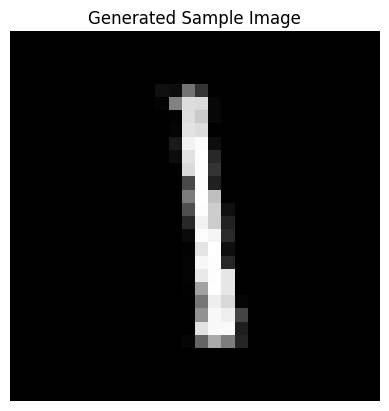

In [ ]:
# Load model from Google Drive
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
saved_model_url = "https://drive.google.com/uc?id=185hmirtoqDMT35GQ9t_RIT37V7E-QFji"
gdown.download(saved_model_url, "saved_model.pth", quiet=True)
generator.load_state_dict(torch.load('saved_model.pth'))

# Evaluate Results on Random Noise
generator.eval()
with torch.no_grad():
    noise = torch.randn((16, 100)).to(device)
    generated = generator(noise)
    save_image(generated.view(generated.size(0), 1, 28, 28), 'test_result' + '.png')
    gen = generated.view(generated.size(0), 1, 28, 28)

    # Generate sample
    plt.imshow(gen[0][0], cmap="gray") 
    plt.axis("off")
    plt.title("Generated Sample Image")
    plt.plot()

#Result after training

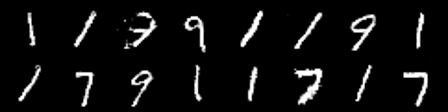

In [ ]:
# Display Results
result_image = Image.open("/content/test_result.png")
result_image = result_image.resize((448, 112))
result_image.show()

# **Human Face Dataset**

Following cell downloads data and loads it with Dataloader. I have resized each image in shape 64 x 64 using transforms.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

from google.colab import drive
drive.mount('/content/drive')
path_to_zip = '/content/drive/MyDrive/human_faces.zip'

# Extract zip file
import zipfile
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

data_dir = '/content/dataset'
dataset = datasets.ImageFolder(data_dir, transform=transform)

face_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

Mounted at /content/drive


#Check Image Size and Display Training Images

Following cells displays image and label size and displays sample training images.

Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])


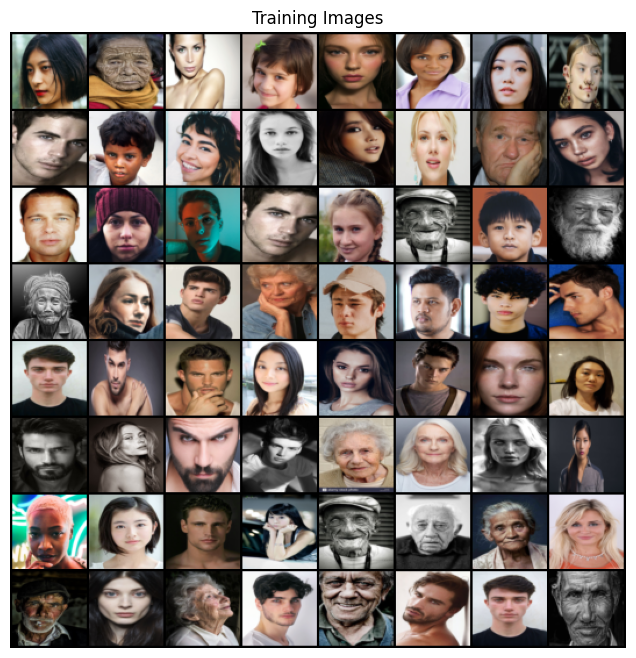

In [ ]:
for images, labels in face_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], padding=2, normalize=True), (1, 2, 0)))

# Define DCGAN Model Architecture

The purpose of using DCGAN for Face dataset is that convolutional layer are famous for capturing specific features and details of an image which would be useful for correct training and generation of images by Generators

In [ ]:
class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()
        
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),          
            nn.Conv2d(64, 128,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 1,
                      kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid()  
        )

            
    def generator_function(self, z):
        x = self.generator(z)
        return x
    
    def discriminator_function(self, img):
        x = model.discriminator(img)
        return x

# Training Loop

I have used a learning rate for 0.0002 for both Generator and Discriminator. Model is being trained for 45 epochs.

Additionally, I have used **log_dict** to save important metrics during training process.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 45
model = DCGAN()
model.to(device)

optimizer_g = torch.optim.Adam(model.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


def train_face_data(num_epochs, model, optimizer_g, optimizer_d, 
                 latent_dim, device, train_loader, criterion=None,
                 save_model=None):
    
    log_dict = {'generator_loss_per_batch': [],
                'discriminator_loss_per_batch': [],
                'discriminator_real_acc_per_batch': [],
                'discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device)

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = model.generator_function(noise)
            fake_labels = torch.zeros(batch_size, device=device)
            flipped_fake_labels = real_labels

            optimizer_d.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_function(real_images).view(-1)
            # print(discr_pred_real.size(), real_labels.size())
            real_loss = criterion(discr_pred_real, real_labels)

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_function(fake_images.detach()).view(-1)
            fake_loss = criterion(discr_pred_fake, fake_labels)

            # combined loss
            loss_d = 0.5*(real_loss + fake_loss)
            loss_d.backward()

            optimizer_d.step()

            optimizer_g.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_function(fake_images).view(-1)
            loss_g = criterion(discr_pred_fake, flipped_fake_labels)
            loss_g.backward()

            optimizer_g.step()

            log_dict['generator_loss_per_batch'].append(loss_g.item())
            log_dict['discriminator_loss_per_batch'].append(loss_d.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100
            log_dict['discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            
            if not batch_idx % 100:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch {batch_idx}/{len(face_loader)}, Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

        # Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_function(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))
            
    end_time = time.time()
    print('Total Training Time: %.2f min' % ((end_time - start_time)/60))
    
    torch.save(model.state_dict(), save_model)
    
    return log_dict

In [ ]:
log_dict = train_face_data(num_epochs=num_epochs, model=model, 
                        optimizer_g=optimizer_g,
                        optimizer_d=optimizer_d,
                        latent_dim=100,
                        device=device, 
                        train_loader=face_loader,
                        save_model='gan_face_data.pt')

Epoch [1/45], Batch 0/55, Loss D: 0.7348, Loss G: 2.3992
Epoch [2/45], Batch 0/55, Loss D: 0.0047, Loss G: 11.5223
Epoch [3/45], Batch 0/55, Loss D: 0.2377, Loss G: 11.6187
Epoch [4/45], Batch 0/55, Loss D: 0.3846, Loss G: 4.9006
Epoch [5/45], Batch 0/55, Loss D: 1.2272, Loss G: 1.9265
Epoch [6/45], Batch 0/55, Loss D: 0.2969, Loss G: 3.1293
Epoch [7/45], Batch 0/55, Loss D: 0.4280, Loss G: 5.5508
Epoch [8/45], Batch 0/55, Loss D: 0.2104, Loss G: 3.2458
Epoch [9/45], Batch 0/55, Loss D: 0.2378, Loss G: 3.1350
Epoch [10/45], Batch 0/55, Loss D: 0.1918, Loss G: 4.0584
Epoch [11/45], Batch 0/55, Loss D: 0.2070, Loss G: 4.2661
Epoch [12/45], Batch 0/55, Loss D: 0.0681, Loss G: 3.5184
Epoch [13/45], Batch 0/55, Loss D: 0.1349, Loss G: 3.5089
Epoch [14/45], Batch 0/55, Loss D: 0.1677, Loss G: 3.6837
Epoch [15/45], Batch 0/55, Loss D: 0.8883, Loss G: 9.9788
Epoch [16/45], Batch 0/55, Loss D: 0.8651, Loss G: 3.9276
Epoch [17/45], Batch 0/55, Loss D: 0.1895, Loss G: 3.4968
Epoch [18/45], Batch 

# Display Results

Display sample results.

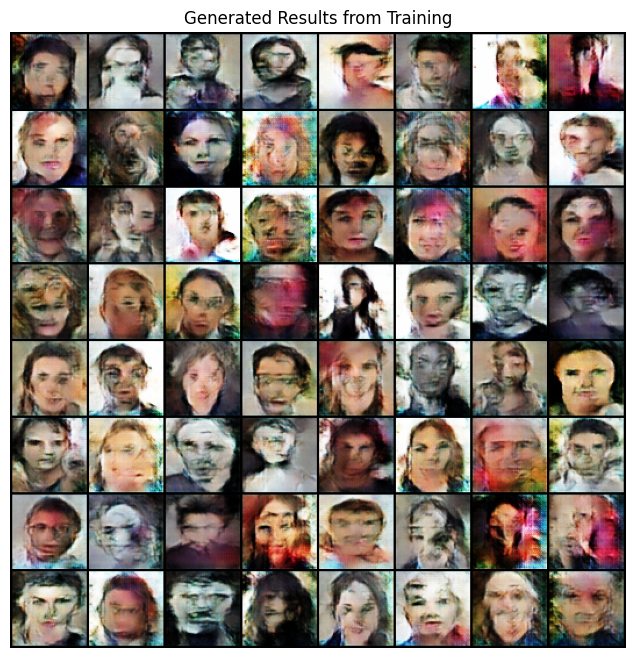

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Generated Results from Training')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

## Save Trained Model

Run following cell to save the model trained of Human Faces Dataset to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !ls /content/drive/My Drive
model_save_name = 'DCGAN.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)
print("Model saved to Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Drive


## Display Result from Generated Noise

Run the following cell to load the custom trained model on Human Faces Dataset and display results.

A model has already been saved on Google Drive. Simply running following cell will display outputs. No need to train again.

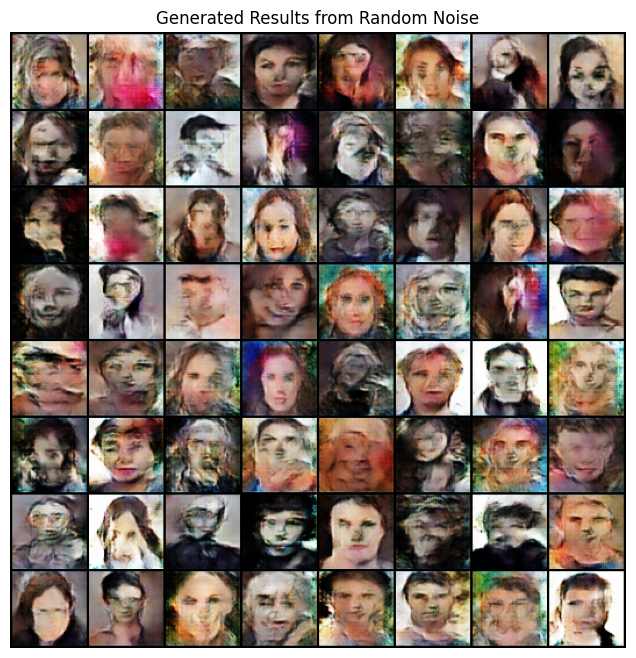

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dcgan = DCGAN().to(device)
saved_model_url = "https://drive.google.com/uc?id=1_HbA7TZtFRyz3fk54en25E7VdAZ0Kw8f"
gdown.download(saved_model_url, "saved_model.pth", quiet=True)
dcgan.load_state_dict(torch.load('saved_model.pth'))

# Evaluate Results on Random Noise
dcgan.eval()
with torch.no_grad():
  fixed_noise_result = torch.randn(64, 100, 1, 1, device=device)
  fake_images_generated = dcgan.generator_function(fixed_noise_result).detach().cpu()
  result = torchvision.utils.make_grid(fake_images_generated, padding=2, normalize=True)

  # Generate sample
  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.title('Generated Results from Random Noise')
  plt.imshow(np.transpose(result, (1, 2, 0)))
  plt.show()

From the above results, we can see that a bit more training can make DCGANs generate better results. I tested the training results on 20 epochs and 40 epochs initially and now displaying the results for 45 epochs. It can also be concluded that GAN requires a longer time to train but is a very powerful tool to help generate new results by using combination of Discriminator and Generator.